# Dementia diagnosis using NPIQ results and AI
- NPIQ stands for Neuropsychiatric Inventory Questionnaire
[- ![image.png](attachment:image.png)](https://www.alz.org/media/documents/npiq-questionnaire.pdf)
- Instead of simply adding each scores, let's use AI to evaluate the results!
- We will take scores for each task and feed it into AI model 
## Preprocessing
- We need to preprocess diagnosis.csv and npiq.csv
### Drop Unnecessary columns and NAs
#### npiq.csv
- column names starting with MM refers to each tasks(Exclude MMLTR~s because they are duplicates)
- PTID and VISDATE is needed for merging with diagnosis data

In [15]:
import pandas as pd
npiq=pd.read_csv('./data/npiq.csv')

NUM_CRITERIA=12
symptoms=['NPI'+chr(i) for i in range(65, 65+NUM_CRITERIA)]
severities=['NPI'+chr(i)+'SEV' for i in range(65, 65+NUM_CRITERIA)]
CRITERIA=severities

In [16]:
print(npiq['NPIA'].value_counts(dropna=False))
npiq=npiq[npiq[symptoms].isin([0,1]).all(axis=1)]
print(npiq['NPIA'].value_counts(dropna=False))

NPIA
 0.0    6809
 1.0     246
 NaN      34
 2.0      19
-1.0      18
Name: count, dtype: int64
NPIA
0.0    6748
1.0     243
Name: count, dtype: int64


In [17]:
print(npiq['NPIASEV'].value_counts(dropna=False))
npiq[severities] = npiq[severities].replace(-4, 0).fillna(0)
print(npiq['NPIASEV'].value_counts(dropna=False))

NPIASEV
-4.0    3640
 NaN    3108
 1.0     137
 2.0      76
 3.0      30
Name: count, dtype: int64
NPIASEV
0.0    6748
1.0     137
2.0      76
3.0      30
Name: count, dtype: int64


In [18]:
npiq = npiq[~((npiq[symptoms] == 1) & (npiq[severities] == 0)).all(axis=1)]


In [19]:
npiq=npiq[['PTID','VISDATE']+severities].dropna()
npiq.to_csv('./cleaned_data/npiq_clean.csv', index=False)

In [11]:
diagnosis=pd.read_csv('./cleaned_data/diagnosis_clean.csv')
diagnosis.rename(columns={'DATE':'VISDATE'}, inplace=True)
npiq=pd.merge(npiq,diagnosis, on=['PTID','VISDATE'], how='inner')

## Modeling

In [12]:
from bayesian import *

npiq['SCORE'] = npiq[CRITERIA].sum(axis=1)
print(npiq['SCORE'].describe())
max_score = 36
print(parameters4censored_data(npiq['SCORE'],min_score=0, max_score=max_score))
print(parameters4each_class(npiq,min_score=0, max_score=max_score))

count    2334.000000
mean        2.246787
std         3.341786
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        29.000000
Name: SCORE, dtype: float64
[1.387084953827172, 4.826801630421839]
{0.0: [-0.8428545224057733, 2.9759566307274126], 1.0: [1.7024643535699329, 4.306624416760022], 2.0: [4.287598552890832, 4.6459878007235105]}


In [13]:
weights = np.ones(len(CRITERIA))
bounds = [(1, 10) for _ in CRITERIA]
labels = npiq['DIAGNOSIS'].values.astype(int)  # Ensure labels are integers from 0 to num_classes - 1
print(labels)
ground_truth = np.eye(3)[labels]  # One-hot encode the labels
class_priors = npiq['DIAGNOSIS'].value_counts(normalize=True)
npiq['SCORE'] = npiq[CRITERIA].sum(axis=1)

[2 1 0 ... 0 0 0]


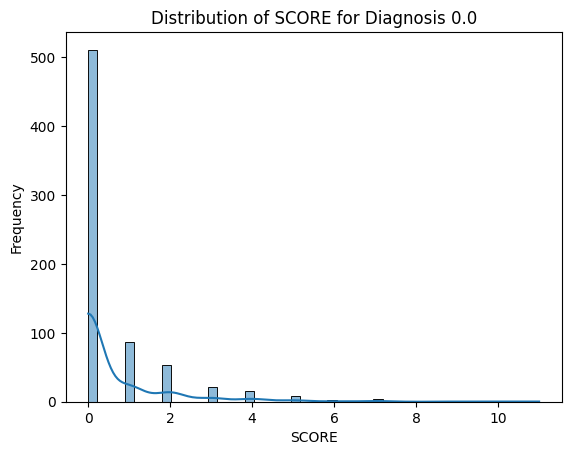

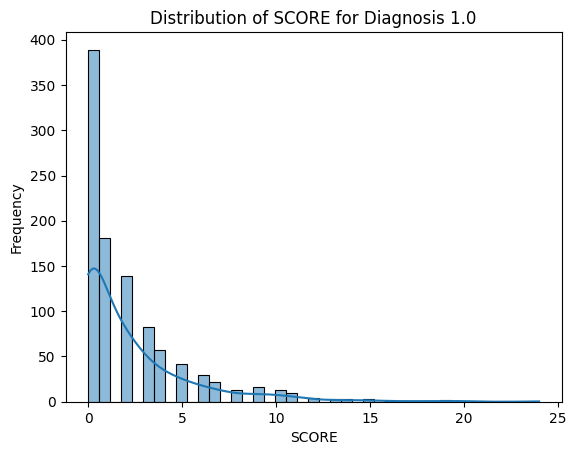

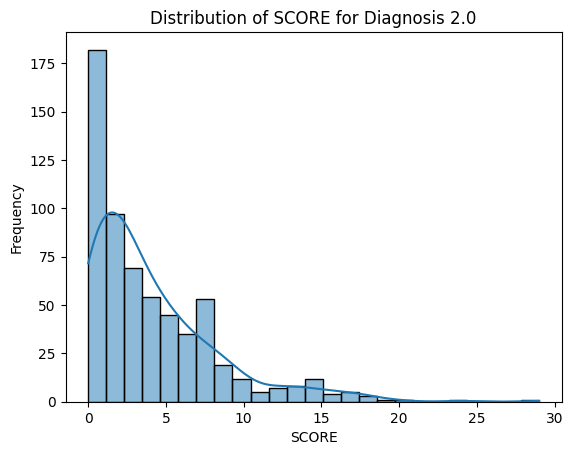

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the npiq dataframe by the "DIAGNOSIS" column
grouped_df = npiq.groupby("DIAGNOSIS")

# Iterate over each diagnosis group
for diagnosis, group in grouped_df:
    # Create a figure and axes for the plot
    fig, ax = plt.subplots()
    
    # Plot the distribution of "SCORE" for the current diagnosis group
    sns.histplot(data=group, x="SCORE", kde=True, ax=ax)
    
    # Set the title and labels for the plot
    ax.set_title(f"Distribution of SCORE for Diagnosis {diagnosis}")
    ax.set_xlabel("SCORE")
    ax.set_ylabel("Frequency")
    
    # Show the plot
    plt.show()


In [11]:
labels = npiq['DIAGNOSIS'].values.astype(int)
from sklearn.metrics import accuracy_score
max_score= weights.sum()
accuracy = accuracy_score(npiq['DIAGNOSIS'], bayesian_classifier(npiq,max_score=max_score,class_priors=class_priors))

print(accuracy)

0.5055698371893744


In [22]:
from flaml import AutoML
automl = AutoML()

# Specify the estimators you want to test
estimators_to_test = ['lgbm', 'lrl1','xgboost','rf', 'extra_tree', 'lrl2']

# Iterate over each estimator
for estimator in estimators_to_test:
    print(f"\nTesting estimator: {estimator}")
    
    # Configure AutoML for each estimator
    automl_settings = {
        "task": 'classification',
        "estimator_list": [estimator],  # Test one estimator at a time
        "verbose": 0,  # silent mode
    }

    # Train the model
    automl.fit(X_train=npiq['SCORE'].to_numpy() , y_train=npiq['DIAGNOSIS'].to_numpy() , **automl_settings)

    # Make predictions
    y_pred = automl.predict(npiq['SCORE'].to_numpy().reshape(-1, 1))

    # Calculate accuracy
    accuracy = accuracy_score(npiq['DIAGNOSIS'].to_numpy() , y_pred)
    print(f"Accuracy for {estimator}: {accuracy:.4f}")



Testing estimator: lgbm
Accuracy for lgbm: 0.5094

Testing estimator: lrl1
Accuracy for lrl1: 0.5034

Testing estimator: xgboost


c:\Users\yeon0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy for xgboost: 0.5099

Testing estimator: rf
Accuracy for rf: 0.5099

Testing estimator: extra_tree
Accuracy for extra_tree: 0.5099

Testing estimator: lrl2
Accuracy for lrl2: 0.5034
